In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class analisis_esolmet:
    #Inicialización de la clase
    def __init__(self,filepath):
        """
            Incializa la clase, carga el archivo parquet y genera un df con las columnas de interés
            Trata de limitar las variables a rangos coherentes
            Define las propiedades de num_elementos y columnas
        """
        self.data = pd.read_parquet(filepath)
        columnas_copiar = ['I_glo_Avg', 'I_dif_Avg','I_dir_Avg','WS_ms_Avg','WindDir','AirTC_Avg','RH','CS106_PB_Avg']
        self.data = self.data[columnas_copiar].copy()
        self.data.columns = ['Ig', 'Id', 'Ib', "ws", 'wd', 'To','rh', 'P']
        self.fecha_min = self.data.index.min()
        self.fecha_max = self.data.index.max()
        self.num_elementos = len(self.data)
        self.columnas = self.data.columns
        #Establece límite a los valores de las variables
        self.set_limites("To",5,45)
        self.set_limites("Ig",0,8000)
        self.set_limites("Id",0,3000)
        self.set_limites("Ib",5,8000)
        self.set_limites("ws",0,16000)
        #temix.set_limites("wd",5,45)
        self.set_limites("rh",5,100)
        self.set_limites("P",400,1500)
    
    #grafica una columna mensual
    def grafica_colum_mensual(self, columna, n_sigma = 1, ver_max_min = False):
        """
            Grafica:
                  Valores promedio mensuales de una columna seleccionada por el usuario
                  n-veces la desviación estándard, donde n es especificado por el usuario, con un default n=1 
                  Valores máximos y mínimos mensuales si el usuario lo especifica, default no
        """
        fig, ax = plt.subplots(figsize=(12,3))
        val_mensual = self.data[columna].resample("ME").mean()
        sigma = self.data[columna].resample("ME").std()
        if ver_max_min:
            val_min = self.data['To'].resample("ME").min()
            val_max = self.data['To'].resample("ME").max()
            ax.plot(val_min,label=columna+"_min")
            ax.plot(val_max,label=columna+"_max")
        
        ax.plot(val_mensual,label=columna+"_prom")
        ax.plot(sigma*n_sigma,label=columna+"_std")
        # ax.set_ylim(0,self._estatica)
        ax.legend()
        plt.show()

    #Ajusta los valores a un rango, el valor lo sustituye por un NaN para no influir en los cálculos     
    def set_limites(self,columna,val_min,val_max):
        """
            Convierte a Nan valores fuera de un rango establecido
        """

        self.data[columna] = np.where(self.data[columna] < val_min, np.nan, self.data[columna])
        self.data[columna] = np.where(self.data[columna] > val_max, np.nan, self.data[columna])

    def quitar_dia(self,df)-> DataFrame:
        """
            Elimina el año, mes y día de una fecha para dejar los registros limitados a hora y minuto
        """                    
        new_index = df.index.map(lambda dt: dt.replace(year=2023, month=1, day=1))    
        df.index = new_index
        
        return df
    
    #Visualizar en el intervalo de un día, los datos de una columna
    def visualiza_dia(self,columna,retorna_df = False) -> DataFrame:
        """
            Grafica:
                  En el intervalo de un dia, una linea por cada día que contenga la serie temporal de la columna seleccionada por el usuario
            Regrese, si lo especifica el usuario, la serie temporal en un df con el indice como datetime
        """
        
        #Los datos se agrupan por año, mes y día
        datos_por_dia = self.data[columna].groupby(by=[self.data.index.strftime("%Y:%m:%D")])
        lista_dfs = [self.quitar_dia(group[1]) for group in datos_por_dia]
        
        dias_completos = pd.concat(lista_dfs, axis=1)
        fig, ax= plt.subplots(figsize=(12,4))

        #Se grafica el conjunto de todos los días
        ax.plot(dias_completos, color='#DBDBDB')

        ax.set_ylabel(columna)
        ax.set_xlabel('Hora')
        ax.legend()
        plt.show()
        if retorna_df == True:
            return dias_completos
    
    #Visualizar mapa de calor
    def mapa_calor(self, columna = "To", retorna_df = False)-> DataFrame:
        """
            Grafica:
                Un mapa de calor de la columna especificada y que por default sea la temperatura To
            Regrese, si lo especifica el usuario, la serie temporal un df de los datos
        """
        
        fig,ax = plt.subplots(figsize=(12,4))

        tmx_asfreq = self.data.asfreq("1h").copy()
        mapa_asfreq = tmx_asfreq[columna].groupby(
               by=[tmx_asfreq.index.month, tmx_asfreq.index.hour]
               ).mean().unstack().T
        
        im = ax.imshow(mapa_asfreq,aspect=.2,cmap="jet",vmin=0,vmax=40)
        cbar = ax.figure.colorbar(im, ax=ax)

        ax.set_ylabel("horas")
        ax.set_xlabel("meses")
        if retorna_df == True:
            return mapa_asfreq

#    #Energía de cada una de las componente de la radiación solar para el periodo de tiempo
    def energia_rad_solar(self,inicio = None,fin=None, retorna_df = False)-> DataFrame:
        """
            Calcula la energía de cada una de las componentes de la radiación solar para todo el periodo
                 de tiempo del conjunto de datos o de un periodo específico si se indica, mediante los argumentos "inicio", "fin"
            Regrese un dataframe si lo especifica el usuario
            Grafica:
                Gráfica de barras de las componentes de la radiación solar del periodo especificado e indique el periodo en la gráfica
        """        
        fig, ax = plt.subplots(figsize=(6,3))
        if inicio is None:
            inicio = self.fecha_min
        if fin is None:
            fin = self.fecha_max
        
        categorias = ['Ig', 'Ib', 'Id']
        reg_filtrados = self.data['Ig'].loc[inicio:fin]
        Ig = reg_filtrados.sum()
        reg_filtrados = self.data['Ib'].loc[inicio:fin]
        Ib = reg_filtrados.sum()
        reg_filtrados = self.data['Id'].loc[inicio:fin]
        Id = reg_filtrados.sum()
        
        valores = [Ig, Ib, Id]
        
        ax.bar(categorias,valores)
        ax.grid(alpha=0.2)
        ax.set_xlabel("Radiación solar")
        ax.set_ylabel("Suma de radiación W/m2")
        ax.set_title(f"Niveles de calor periodo: {inicio}  - {fin}")
        
        # Display the chart
        plt.show()
        if retorna_df == True:
            datos = {
                'Tipo_Radiacion':categorias,
                'Suma_radiacion': valores
            }
            df = pd.DataFrame(datos)
            return df
    

In [3]:
temix = analisis_esolmet("../data/002_processed/esolmet_2022_2023.parquet") 

In [4]:
temix.num_elementos

52423

In [5]:
temix.columnas

Index(['Ig', 'Id', 'Ib', 'ws', 'wd', 'To', 'rh', 'P'], dtype='object')

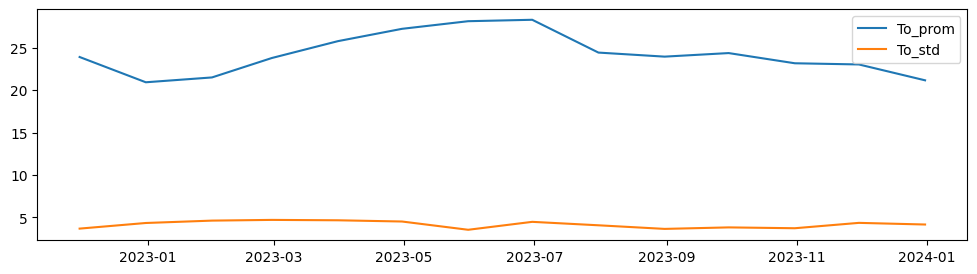

In [6]:
temix.grafica_colum_mensual("To")

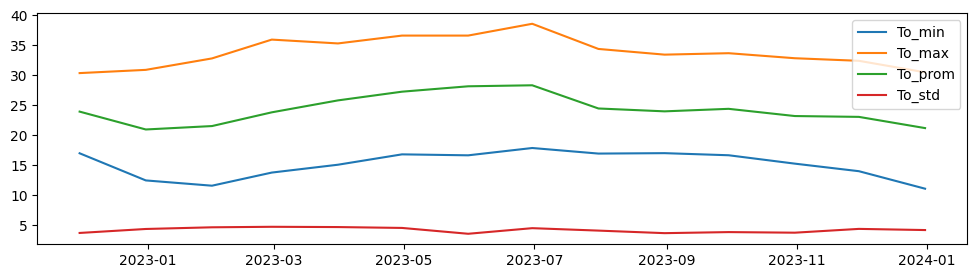

In [7]:
temix.grafica_colum_mensual("To",ver_max_min = True)

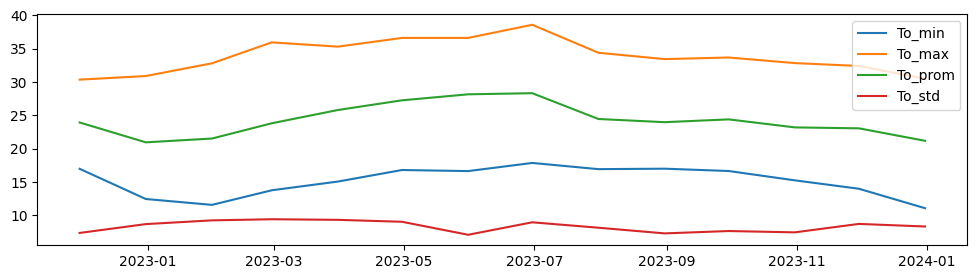

In [8]:
temix.grafica_colum_mensual("To",n_sigma = 2,ver_max_min = True)

C:\Users\luisa\AppData\Local\Temp\ipykernel_2172\2441727833.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


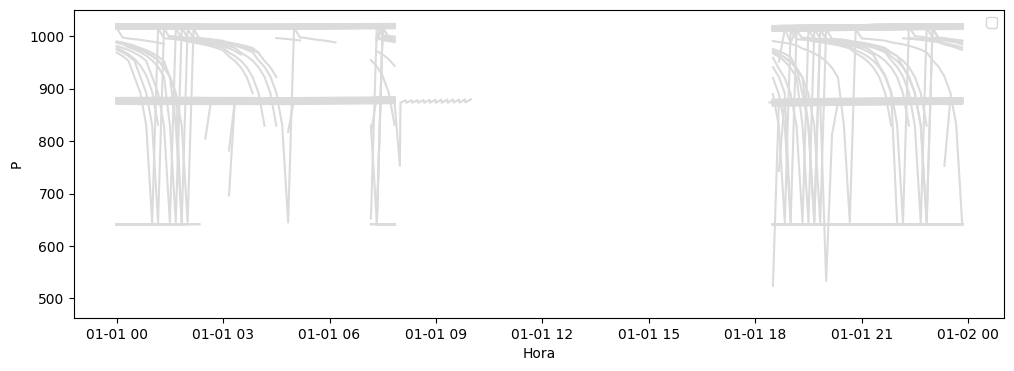

,P,P,P,P,P,P,P,P,P,P,...,P,P,P,P,P,P,P,P,P,P
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,NaN,876.5488,877.8496,880.2456,881.1292,881.9717,879.6486,876.4614,878.4631,880.3270,...,877.0541,877.6400,877.1306,876.7037,877.0623,877.7676,876.3783,876.6752,876.8353,878.3892
2023-01-01 00:10:00,NaN,876.5248,877.7923,880.1396,881.0964,882.0943,879.5115,876.4932,878.5205,880.4473,...,877.1074,877.6673,877.0779,876.6251,877.0862,877.7324,876.2911,876.6214,876.8584,878.3478
2023-01-01 00:20:00,NaN,876.5326,877.8087,880.1229,881.0964,882.0942,879.4792,876.6282,878.4958,880.3728,...,877.1136,877.6759,877.0885,876.5858,877.0945,877.7127,876.2166,876.5717,876.8439,878.0850
2023-01-01 00:30:00,NaN,876.4583,878.0382,880.0824,881.0802,882.1024,879.4857,876.6181,878.4951,880.2695,...,877.0674,877.6663,877.1198,876.5966,877.0957,877.6260,876.0848,876.4716,876.7212,877.9251
2023-01-01 00:40:00,NaN,876.3290,878.1443,880.0906,881.1209,882.0942,879.4855,876.6930,878.5211,880.4169,...,876.9653,877.5990,877.0211,876.5645,877.1958,877.6398,875.9640,876.4850,876.6439,877.7667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 23:10:00,876.8680,877.9960,880.5727,881.2028,882.0208,879.9838,876.2878,878.1605,880.1636,879.3458,...,877.6617,877.1061,876.6360,876.9485,877.6935,876.4833,876.5765,876.7314,878.4079,NaN
2023-01-01 23:20:00,876.7945,878.0543,880.4667,881.1699,882.0203,879.9106,876.4502,878.3896,880.0496,879.2482,...,877.6493,877.1144,876.7103,877.0175,877.6716,876.3633,876.5290,876.6924,878.6281,NaN
2023-01-01 23:30:00,876.7453,878.0292,880.4667,881.0883,881.8731,879.8368,876.3616,878.3567,880.0059,879.1666,...,877.7139,877.2256,876.7289,877.1051,877.7072,876.4707,876.6237,876.7372,878.6579,NaN


In [9]:
temix.visualiza_dia("P",retorna_df=True)

TIMESTAMP,1,2,3,4,5,6,7,8,9,10,11,12
TIMESTAMP,,,,,,,,,,,,
0,18.836154,20.712593,23.397241,24.369643,24.670000,26.033103,21.835806,21.618710,21.931000,20.962581,21.196774,18.913966
1,18.335385,20.058077,22.483448,23.538214,24.382727,25.283793,21.535161,21.112581,21.484667,20.606129,20.335806,18.287414
2,17.710000,19.440800,21.717241,22.653462,23.682500,24.387241,21.135806,20.853226,21.070333,20.258065,19.558387,17.756207
3,17.119615,18.949231,20.937931,22.033333,NaN,23.696897,20.707097,20.419355,20.675000,19.888065,18.905806,17.303621
4,16.839231,18.952400,20.356552,21.374348,NaN,23.073103,20.353226,20.228387,20.471333,19.467742,18.592581,16.689483
5,16.700000,18.839583,19.884483,20.785263,NaN,22.558966,20.092903,19.751613,19.950000,19.123871,18.061935,16.316207
6,16.230417,18.540400,19.382759,20.368125,NaN,22.175517,19.824194,19.551613,19.540333,18.804839,17.553548,15.962759
7,15.717391,18.475185,18.832759,20.535833,NaN,22.926552,20.057419,19.571290,19.362667,18.768710,17.266452,15.563103
8,16.127391,19.461852,21.465517,24.409630,24.999048,26.356667,22.279032,21.999677,22.334667,20.813548,19.368387,16.379138


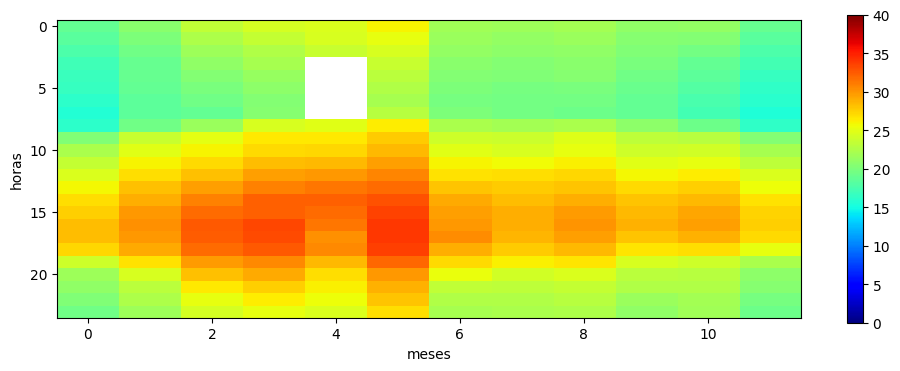

In [10]:
temix.mapa_calor(retorna_df=True)

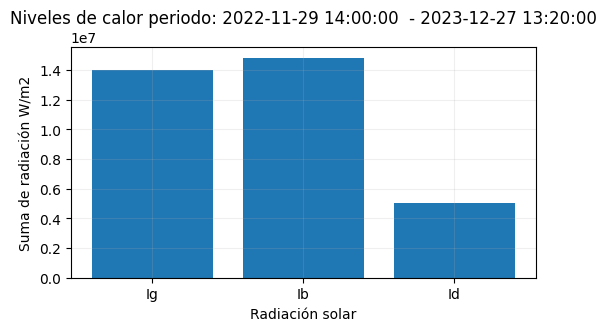

,Tipo_Radiacion,Suma_radiacion
0,Ig,1.398987e+07
1,Ib,1.483496e+07
2,Id,5.026853e+06


In [11]:
temix.energia_rad_solar(retorna_df=True)

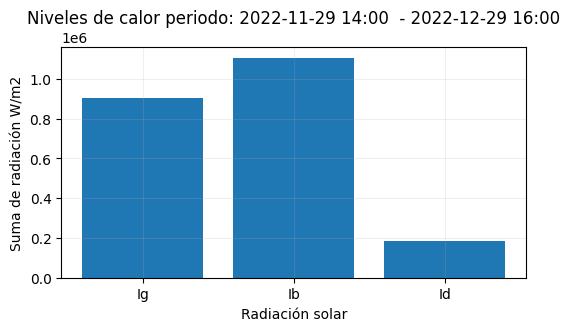

In [12]:
temix.energia_rad_solar(inicio="2022-11-29 14:00",fin="2022-12-29 16:00")

temix.visualiza_dia("To")

In [13]:
temix.data.describe()

,Ig,Id,Ib,ws,wd,To,rh,P
count,52229.000000,52212.000000,25739.000000,52423.000000,52301.000000,52394.000000,38558.000000,52105.000000
mean,267.856316,96.277727,576.361348,1.554274,185.517022,24.166030,60.218250,924.648529
std,424.234613,202.042799,632.396969,0.969415,126.009863,4.799046,22.118206,91.179681
min,0.000000,0.000000,5.008000,0.000000,0.000000,11.060000,12.300000,489.924100
25%,0.000000,0.000000,228.250000,0.920000,67.020000,20.290000,43.180000,875.960500
50%,4.919000,1.686000,611.200000,1.581000,181.700000,24.010000,59.425000,878.974600
75%,532.200000,116.300000,785.700000,2.130000,321.300000,27.740000,76.860000,1016.976000
max,7999.000000,2990.000000,7999.000000,12.100000,354.500000,38.580000,100.000000,1023.585000


In [14]:
temix.columnas

Index(['Ig', 'Id', 'Ib', 'ws', 'wd', 'To', 'rh', 'P'], dtype='object')